# US Gun Violence

In [ ]:
#pip install geopandas

In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
dtypes = {"state": "category","killed": "float"}

In [3]:
# read the Gun Violence dataset using the compression zip
df = pd.read_csv('Gun_Violence.zip', compression='zip',
                  dtype = dtypes,
                  parse_dates=['incident_date'],
                  index_col = 'incident_date')

In [4]:
# Read the state populations dataset 
pop = pd.read_csv('~/Test/Springboard/US_Gun_Violence/Data/State_Populations.csv')

In [5]:
# Rename state column in pops df in prep of upcoming merge
pop.rename(columns={'State': 'state'}, inplace=True)

In [6]:
df.head()

,incident_id,state,city_or_county,address,killed,injured
incident_date,,,,,,
2021-09-29,2128682,Illinois,Chicago,800 block of N Milwaukee Ave,0.0,5.0
2021-09-28,2127374,Illinois,Chicago,65th St and Calumet Ave,1.0,3.0
2021-09-28,2128023,Minnesota,Minneapolis,2700 block of Bloomington Ave,1.0,3.0
2021-09-27,2126747,New York,New York (Manhattan),3964 10th Ave,0.0,5.0
2021-09-27,2126450,Illinois,Chicago,826 N Ridgeway Ave,1.0,3.0


In [7]:
df.tail()

,incident_id,state,city_or_county,address,killed,injured
incident_date,,,,,,
2014-01-12,95550,Alabama,Huntsville,University Drive,0.0,5.0
2014-01-11,95146,Mississippi,Jackson,3430 W. Capitol Street,0.0,4.0
2014-01-05,94514,Pennsylvania,Erie,829 Parade St,1.0,3.0
2014-01-03,92704,New York,Queens,Farmers Boulevard and 133rd Avenue,1.0,3.0
2014-01-01,92194,Virginia,Norfolk,Rockingham Street and Berkley Avenue Extended,2.0,2.0


**How do total casualties (both fatalities and injuries) over the entire span of time (2014-2021) compare between states?**
Let's group the data by state and compute the total number of injuries and fatalities per state. To do this, we'll use `groupby` and then sort the values in descending order using `sort_values`. Then we'll plot this data in a grouped bar chart below.

In [8]:
df_state=df.groupby('state')[['injured', 'killed']].sum().sort_values(by='injured', ascending=False)

In [9]:
df_state.reset_index(inplace=True)

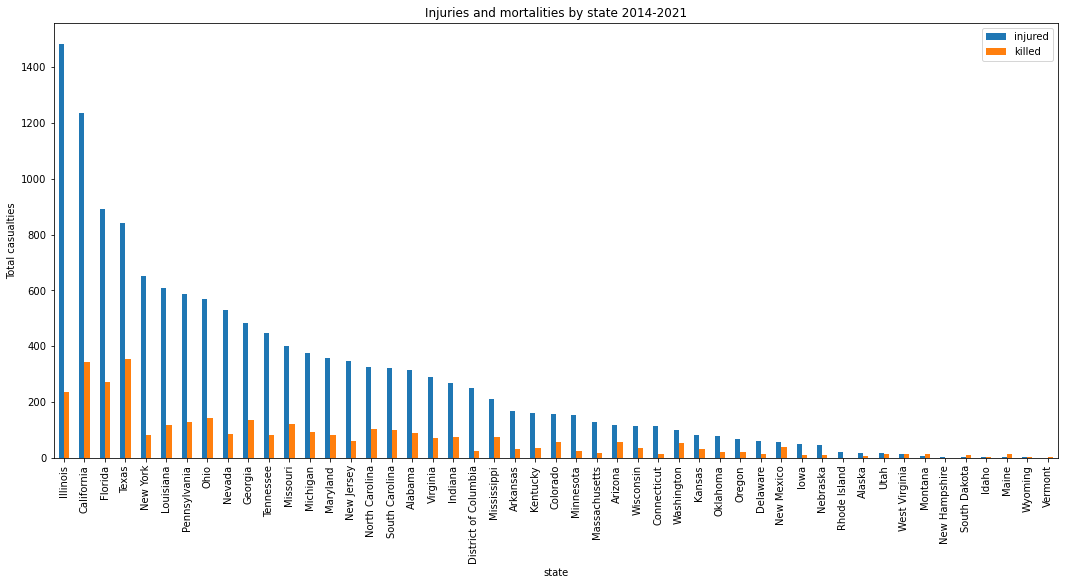

In [10]:
#fig = plt.figure(figsize=(8, 6))
df_state.plot(x='state',
              kind='bar',
              stacked=False,
              title='Injuries and mortalities by state 2014-2021',
              ylabel = 'Total casualties',
              figsize=(18,8))
plt.show()

That's a great start, but it may be easier to visualize this information as a graphical or map chart. Let's import the US .shp data for use with geopandas and then re-plot the information above. We'll drop Alaska and Hawaii for now to simplify the visualization and conserve space.

In [11]:
fp = '~/Test/Springboard/US_Gun_Violence/Data/geo_export_13390475-3a1c-4c1a-b57d-965976a165df.shp'
states = (gpd.read_file(fp)).to_crs("EPSG:3395")

In [12]:
states2= states.copy()

In [13]:
states2.drop(columns=['drawseq'], inplace=True)

In [14]:
states2.rename(columns={'state_name':'state'}, inplace=True)
df_state.rename(columns={'injured': 'Injured', 'killed': 'Killed'}, inplace = True)

In [15]:
new_df = pd.merge(states2, df_state, on='state')

In [17]:
def map_col(col, df, title):
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 10))
    # create map
    df.plot(column=col, cmap='Reds', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
    # remove the axis
    ax.axis('off')
    # add a title
    ax.set_title(title, fontdict={'fontsize': '14', 'fontweight' : '3'})
    plt.show()

In [18]:
cont_df= new_df[new_df['state']!='Alaska']
cont_df = cont_df[cont_df['state']!='Hawaii']

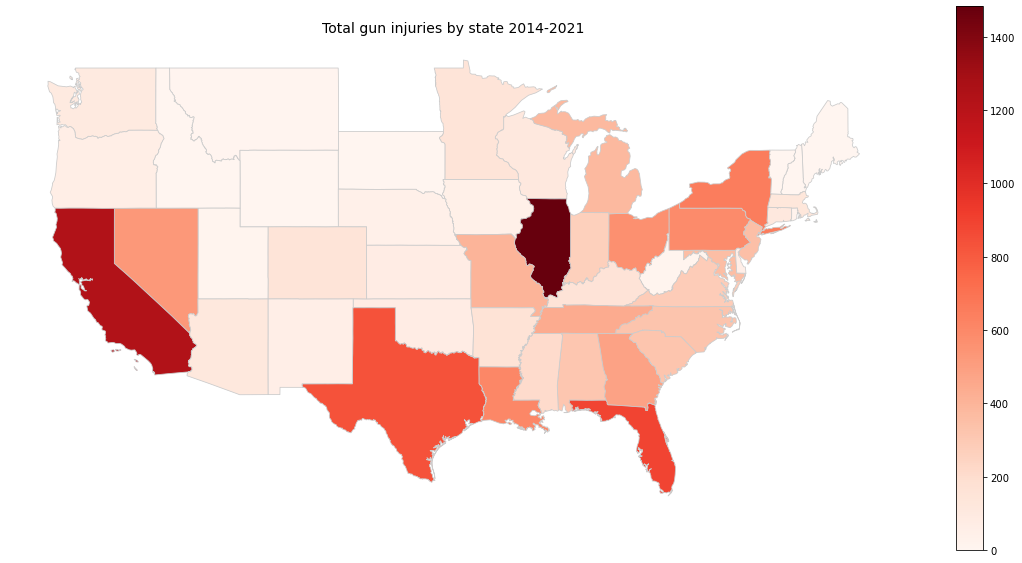

In [19]:
map_col('Injured', cont_df, 'Total gun injuries by state 2014-2021')

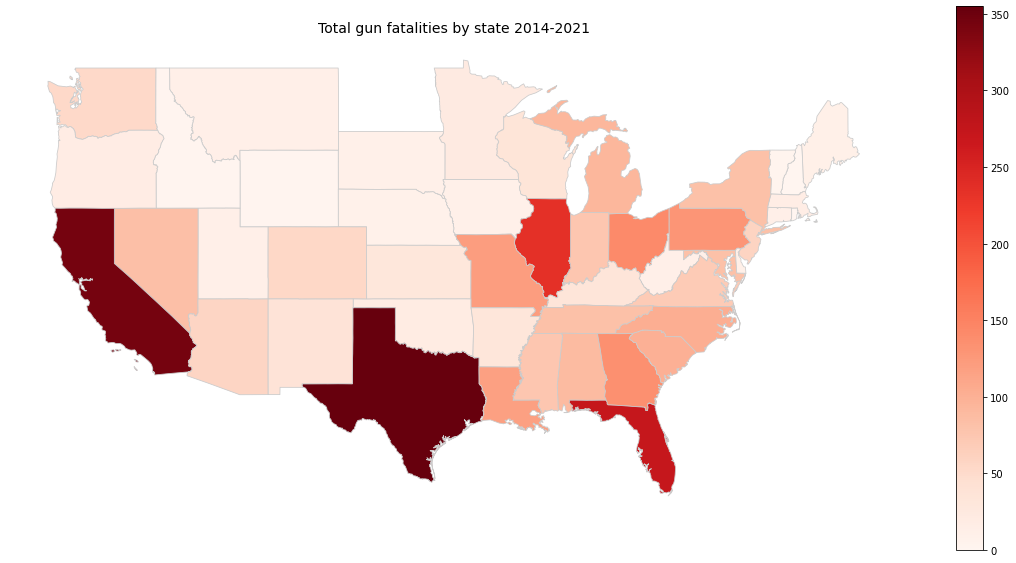

In [20]:
map_col('Killed', cont_df, 'Total gun fatalities by state 2014-2021')

This is much easier to read, but we might reasonably have predicted California and Texas to have some of the highest total number of... well, anything, really (since they are two of the most populous states!). It seems cumulative totals might be a bit misleading since different states have such vastly different population densities. Let's re-plot this data as total number of injuries and fatalities *as a percent of total population* per state.

**How do gun violence casualties in the US compare between states *as percents of total population*?**

In [21]:
pct_df = pd.merge(cont_df, pop, on='state')

In [22]:
pct_df['Injured_pct'] = pct_df['Injured']*1000000//pct_df['2018 Population']
pct_df['Killed_pct'] = pct_df['Killed']*1000000//pct_df['2018 Population']

In [23]:
pct_df.drop(columns=['Injured', 'Killed', '2018 Population'], inplace=True)

In [24]:
pct_df = pct_df.sort_values(by='Injured_pct', ascending=False)

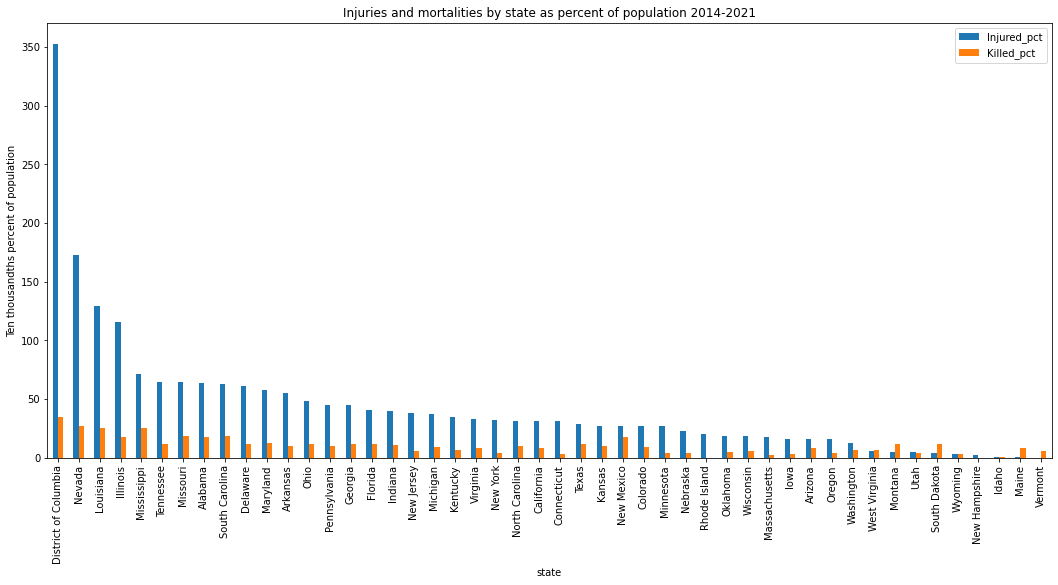

In [25]:
#fig = plt.figure(figsize=(8, 6))
pct_df.plot(x='state',
              kind='bar',
              stacked=False,
              title='Injuries and mortalities by state as percent of population 2014-2021',
              ylabel= 'Ten thousandths percent of population', 
              figsize=(18,8))
plt.show()

Washington D.C. seems to be an outlier than may be skewing our graph. Let's drop that column for now and re-visualize.

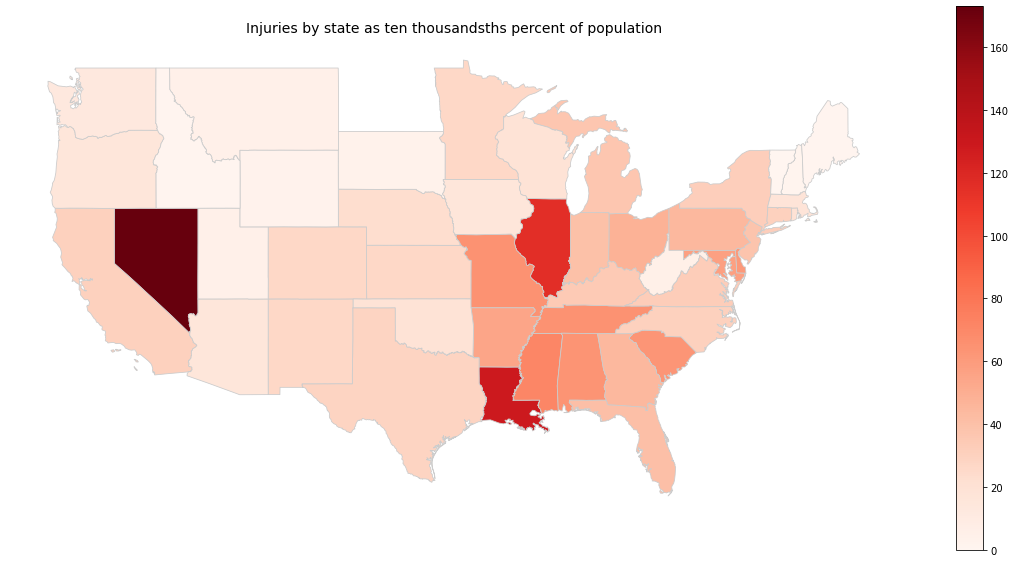

In [26]:
map_col('Injured_pct', pct_df[pct_df['state'] != 'District of Columbia'], 'Injuries by state as ten thousandsths percent of population')

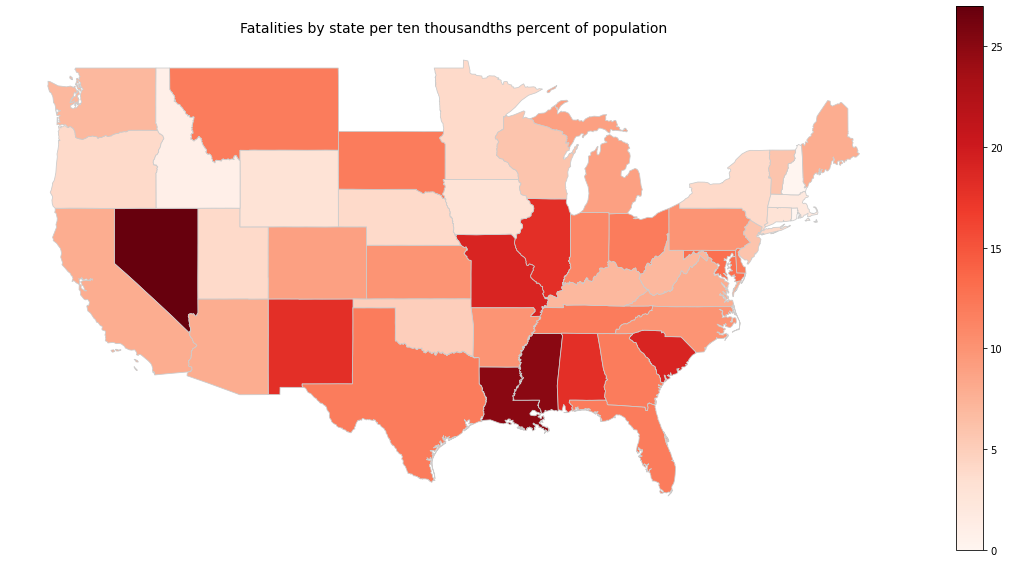

In [27]:
map_col('Killed_pct', pct_df[pct_df['state'] != 'District of Columbia'], 'Fatalities by state per ten thousandths percent of population')

Now let's try visualizing the data over time. Let's group the data by state and year and then re-visualize it as a line plot over time. If we plot all of the states in one plot, we will likely get a very confusing mess of lines. If we plot each state individually, we'll have a lot of different plots. Let's plot regions of the US instead. We'll first define each of the nine regions of the US, and then we'll plot each region individually (for nine separate plots).

**Are there any trends in gun casualties based on region of the US?**

In [28]:
df.head()

,incident_id,state,city_or_county,address,killed,injured
incident_date,,,,,,
2021-09-29,2128682,Illinois,Chicago,800 block of N Milwaukee Ave,0.0,5.0
2021-09-28,2127374,Illinois,Chicago,65th St and Calumet Ave,1.0,3.0
2021-09-28,2128023,Minnesota,Minneapolis,2700 block of Bloomington Ave,1.0,3.0
2021-09-27,2126747,New York,New York (Manhattan),3964 10th Ave,0.0,5.0
2021-09-27,2126450,Illinois,Chicago,826 N Ridgeway Ave,1.0,3.0


In [29]:
df_yearly = df.reset_index()

In [30]:
df_yearly.dtypes

incident_date     datetime64[ns]
incident_id                int64
state                   category
city_or_county            object
address                   object
killed                   float64
injured                  float64
dtype: object

In [31]:
df_yearly['year'] = [i.year for i in df_yearly['incident_date']]

In [32]:
df_yearly['year'] = df_yearly[['year', 'state']].astype('category')

In [33]:
df_yearly = df_yearly.groupby(['state','year']).sum()
df_yearly = df_yearly.drop(columns='incident_id')

In [34]:
df_yearly.reset_index(inplace=True)

In [36]:
df_yearly_killed = df_yearly.drop(columns=['injured'])

In [37]:
df_yearly_killed = df_yearly_killed.pivot(index='state', columns='year', values='killed').T

In [38]:
# Define regions of the US:
new_england = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
mid_atlantic = ['New Jersey', 'New York', 'Pennsylvania']
east_north_central = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin']
west_north_central = ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska','South Dakota']
south_atlantic = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia']
east_south_central = ['Alabama', 'Kentucky', 'Tennessee', 'Mississippi']
west_south_central = ['Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
mountain = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming']
pacific = ['Alaska', 'California', 'Washington', 'Oregon']

In [39]:
# Define list of regions:
regions = [new_england, mid_atlantic, east_north_central, west_north_central, south_atlantic, 
           east_south_central, west_south_central, mountain, pacific]

In [40]:
regions_names = ['New England', 'the Mid Atlantic', 'the East North Central US', 'the West North Central US', 'the South Atlantic', 
           'the East South Central US', 'the West South Central US', 'the Mountain region of US', 'the US Pacific']

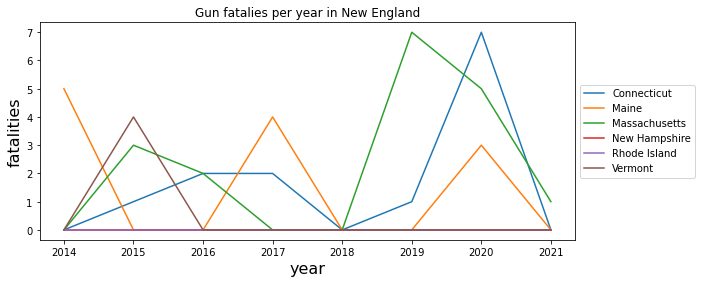

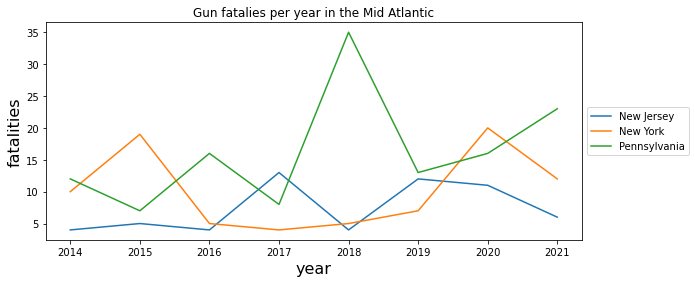

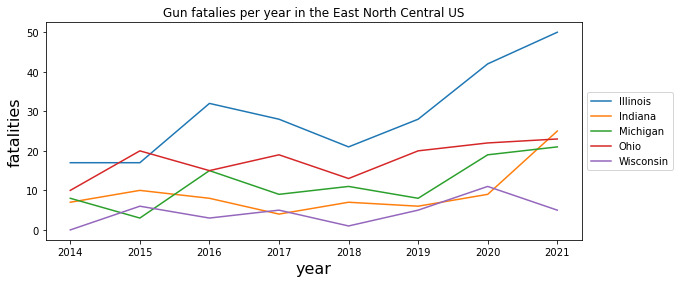

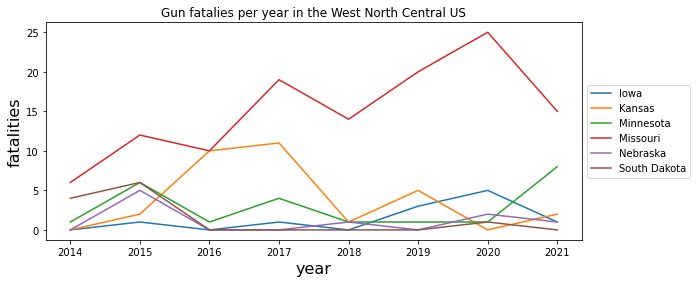

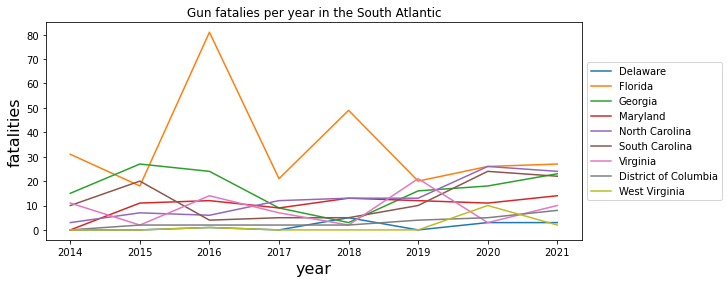

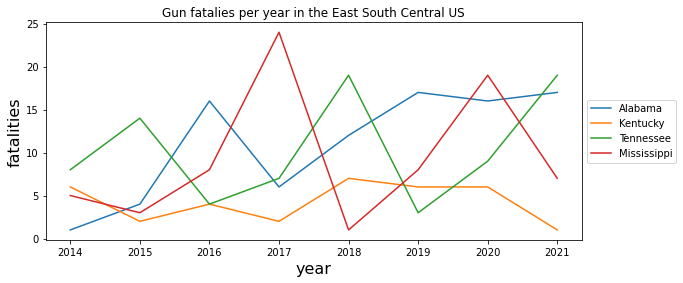

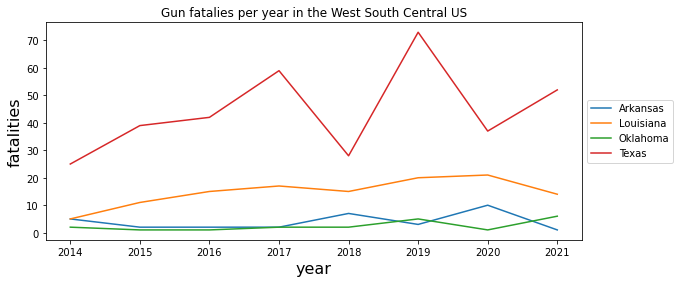

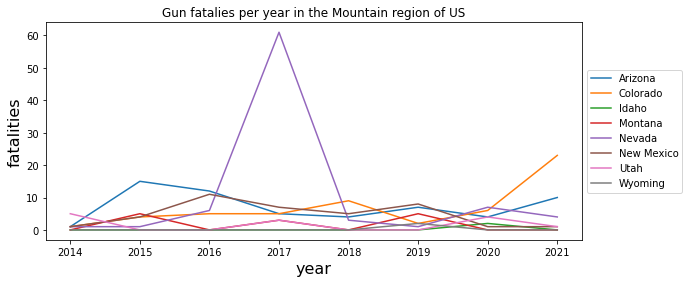

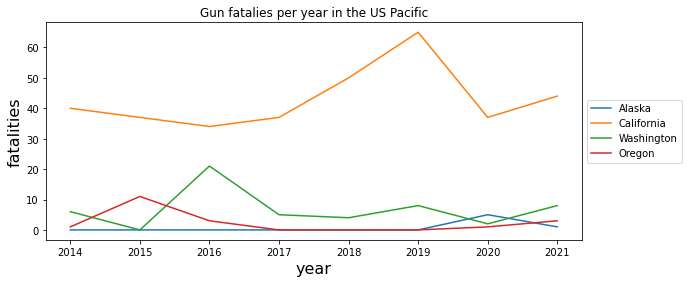

In [41]:
name=0
for region in regions:
    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    ax.plot(df_yearly_killed[region])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(region, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Gun fatalies per year in '+ regions_names[name])
    ax.set_xlabel('year', fontsize=16)
    ax.set_ylabel('fatalities', fontsize=16)
    name +=1
    plt.show()
    